In [1]:
from typing import TypedDict, Optional, List, Callable, Dict, Any, Literal
from typing_extensions import Annotated
import os
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from youtube_transcript_api import YouTubeTranscriptApi
from langgraph.graph import StateGraph, add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import START, END

In [2]:
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
class BlogGenState(TypedDict):
    yt_url: Optional[str]
    transcripts: Optional[str]
    blog_title: Optional[str]
    blog_content: Optional[str]
    regenerate_status: Optional[str]
    message: Annotated[list[AnyMessage], add_messages]

In [ ]:
class Agents:
    def __init__(self):
        self.llm = ChatGroq(model="qwen-2.5-32b")
    def generate_blog(self, state: BlogGenState) -> BlogGenState:
        """
        Generates a title and content for the blog based on the transcript.
        
        Args:
            state: The current state of the workflow
            
        Returns:
            Updated state with blog title and content
        """
        if state["transcript"] is None:
            video_id = state["yt_url"].split("v=")[-1].split("&")[0]
            transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
            full_transcript = " ".join([entry['text'] for entry in transcript_list])
            state["transcript"] = full_transcript

        title_prompt = [
            SystemMessage(content="You are an expert in generating titles for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE TITLES FOR THE BLOG. NO EXPLANATION IS REQUIRED."),
            HumanMessage(content=f"Generate a good blog title for a video with the following transcript: {state['transcript']}")
        ]
        blog_title = self.llm.invoke(title_prompt).content.strip()

        content_prompt = [
            SystemMessage(content="""You are an expert in generating content for BLOG posts based on the transcripts of YouTube videos. 
            IMPORTANT: YOU SIMPLY ONLY CREATE CONTENT FOR THE BLOG. THE TITLE IS ALREADY PROVIDED. 
            Output format: Simply output the content in markdown format with appropriate headings, paragraphs, and formatting."""),
            HumanMessage(content=f"Generate blog content for the title '{blog_title}' based on the following transcript: {state['transcript']}")
        ]
        blog_content = self.llm.invoke(content_prompt).content.strip()

        return {
            "blog_title": blog_title,
            "blog_content": blog_content,
            "message": state["message"] + [
                SystemMessage(content="Transcript fetched successfully."),
                SystemMessage(content=f"Blog title generated: {blog_title}"),
                SystemMessage(content="Blog content generated successfully.")
            ]
        }
    def human_feedback(self, state: BlogGenState) -> BlogGenState:
        """Just an empty to update the feedback param"""
        return state

In [9]:
class BlogGenGraph:
    def __init__(self):
        self.agents = Agents()
    def regenerate_condition_or_not(self, state: BlogGenState) -> Literal["regenerate","end"]:
        if state["regenerate_status"] == "yes":
            return "regenerate"
        else:    
            return "end" 
    def create_graph(self):
        graph_builder = StateGraph(BlogGenState)
        graph_builder.add_node("generate_blog_with_title",self.agents.generate_blog)
        graph_builder.add_node("human_feedback",self.agents.human_feedback)
        graph_builder.add_edge("generate_blog_with_title","human_feedback")
        graph_builder.add_conditional_edges("human_feedback",self.regenerate_condition_or_not, {"regenerate": "generate_blog_with_title", "end": END})

        graph_builder.set_entry_point("generate_blog_with_title")

        memory = MemorySaver()
        graph = graph_builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])
        return graph

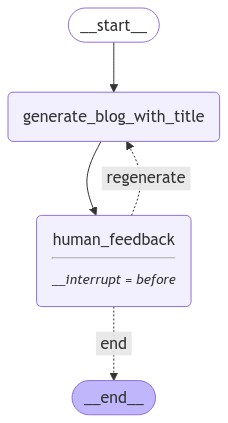

In [10]:
graph = BlogGenGraph().create_graph()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))